# Generates crops ad pickle file using dataset_gen_pipe

This notebook crops images according to bounding box coordinates (one per sulcus)

# Imports

In [1]:
import sys
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the aims module
from soma import aims
# the brainplot package
import colorado as cld

print((sys.version))

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]


The following line permits to import deep_folding even if this notebook is executed from the notebooks subfolder (and no install has been launched):

 /notebooks/use_transform.ipynb  
 /deep_folding/__init__.py

In [2]:
sys.path.append((os.path.abspath('../')))
import deep_folding
print((os.path.dirname(deep_folding.__file__)))

/host/home/jc225751/Program/deep_folding/deep_folding


In [3]:
_ALL_SUBJECTS = -1

# User-specific variables

In [4]:
sulcus = 'S.T.s.ter.asc.ant._left'

In [5]:
side = 'L'

We now assign path names and other user-specific variables.

The source directory is where the database lies. It contains the morphologist analysis subfolder ANALYSIS/3T_morphologist


In [6]:
src_dir = os.path.join(os.getcwd(), '../data/source/unsupervised')
src_dir = os.path.abspath(src_dir)
print(("src_dir = " + src_dir))

src_dir = /host/home/jc225751/Program/deep_folding/data/source/unsupervised


The target directory tgt_dir is where the files will be saved

In [7]:
tgt_dir = os.path.join(os.getcwd(), '../data/target/data/linear')
tgt_dir = os.path.abspath(tgt_dir)
print(("tgt_dir = " + tgt_dir))

tgt_dir = /host/home/jc225751/Program/deep_folding/data/target/data/linear


The reference directory is where the equivalent reference file has been saved

In [8]:
ref_dir = os.path.join(os.getcwd(), '../data/reference/data/linear')
ref_dir = os.path.abspath(ref_dir)
print(("ref_dir = " + ref_dir))

ref_dir = /host/home/jc225751/Program/deep_folding/data/reference/data/linear


In [9]:
transform_dir = os.path.join(os.getcwd(), '../data/reference/transform')
transform_dir = os.path.abspath(transform_dir)
print(("transform_dir = " + transform_dir))

transform_dir = /host/home/jc225751/Program/deep_folding/data/reference/transform


In [10]:
bbox_dir = os.path.join(os.getcwd(), '../data/reference/bbox')
bbox_dir = os.path.abspath(bbox_dir)
print(("bbox_dir = " + bbox_dir))

bbox_dir = /host/home/jc225751/Program/deep_folding/data/reference/bbox


In [11]:
print((sys.argv))

['/home/jc225751/Program/deep_folding/venv/lib/python3.6/site-packages/ipykernel_launcher.py', '-f', '/casa/home/.local/share/jupyter/runtime/kernel-7ebbd46e-f2cd-49fa-8ae6-f7dc166abad3.json']


# Illustration of main program uses

We will first use the program with no effect by using number of subjects set to 0, or by calling the help function

### Using external calls

In [12]:
!python ../deep_folding/anatomist_tools/dataset_gen_pipe.py -n 0 -t tgt_local_dir

In [13]:
# Clean
!rm -rf tgt_local_dir

In [14]:
!python ../deep_folding/anatomist_tools/bounding_box.py --help

usage: bounding_box.py [-h] [-s SRC_DIR [SRC_DIR ...]] [-t TGT_DIR]
                       [-u SULCUS] [-i SIDE] [-m IMAGE_NORMALIZED_SPM]
                       [-p PATH_TO_GRAPH] [-n NB_SUBJECTS]

Computes bounding box around the named sulcus

optional arguments:
  -h, --help            show this help message and exit
  -s SRC_DIR [SRC_DIR ...], --src_dir SRC_DIR [SRC_DIR ...]
                        Source directory where the MRI data lies. If there are
                        several directories, add all directories one after the
                        other. Example: -s DIR_1 DIR_2. Default is :
                        /neurospin/lnao/PClean/database_learnclean/all/
  -t TGT_DIR, --tgt_dir TGT_DIR
                        Target directory where to store the output
                        transformation files. Default is :
                        /neurospin/dico/deep_folding_data/test/bbox
  -u SULCUS, --sulcus SULCUS
                        Sulcus name around which we determine th

### By using the main function call

In [15]:
from deep_folding.anatomist_tools import dataset_gen_pipe
print((dataset_gen_pipe.__file__))

/host/home/jc225751/Program/deep_folding/deep_folding/anatomist_tools/dataset_gen_pipe.py


In [16]:
args = "-n 0 -t " + tgt_dir
argv = args.split(' ')

In [17]:
dataset_gen_pipe.main(argv)

In [18]:
args = "--help"
argv = args.split(' ')

In [19]:
dataset_gen_pipe.main(argv)

usage: dataset_gen_pipe.py [-h] [-s SRC_DIR] [-t TGT_DIR] [-r TRANSFORM_DIR]
                           [-b BBOX_DIR] [-u SULCUS [SULCUS ...]] [-i SIDE]
                           [-n NB_SUBJECTS] [-e INTERP]

Generates cropped and pickle files

optional arguments:
  -h, --help            show this help message and exit
  -s SRC_DIR, --src_dir SRC_DIR
                        Source directory where the MRI data lies. Default is :
                        /neurospin/hcp
  -t TGT_DIR, --tgt_dir TGT_DIR
                        Target directory where to store the cropped and pickle
                        files. Default is :
                        /neurospin/dico/deep_folding_data/test
  -r TRANSFORM_DIR, --transform_dir TRANSFORM_DIR
                        Transform directory where transformation files from
                        native to Talairach files have been stored. Default is
                        : /neurospin/dico/deep_folding_data/test/transform
  -b BBOX_DIR, --bbox_dir BBOX

### By using the API function call

In [20]:
dataset_gen_pipe.dataset_gen_pipe(src_dir=src_dir,
                                  tgt_dir=tgt_dir,
                                  transform_dir=transform_dir,
                                  bbox_dir=bbox_dir,
                                  list_sulci=sulcus,
                                  side=side,
                                  number_subjects=0)

# Crops with linear interpolation

## Main program

In [21]:
interp = 'linear'

In [22]:
dataset_gen_pipe.dataset_gen_pipe(src_dir=src_dir,
                                  tgt_dir=tgt_dir,
                                  transform_dir=transform_dir,
                                  bbox_dir=bbox_dir,
                                  list_sulci=sulcus,
                                  side=side,
                                  interp=interp,
                                  number_subjects=_ALL_SUBJECTS)

## Result analysis

### Analysis of the inputs

In [23]:
# Gets source file as numpy array
skeleton_dir = os.path.join(src_dir, "ANALYSIS/3T_morphologist/100206/t1mri/default_acquisition/default_analysis/segmentation")
vol_source_file = glob.glob(skeleton_dir + '/' + side + '*.nii.gz')
vol_source = aims.read(vol_source_file[0])
arr_source = vol_source.arraydata()
print("shape of source skeleton = ", arr_source.shape)

shape of source skeleton =  (1, 260, 311, 260)


In [24]:
np.unique(arr_source)

array([ 0, 10, 11, 30, 40, 60, 80], dtype=int16)

In [25]:
pd.value_counts(np.resize(arr_source, arr_source.size))

11    18832738
0      2012736
60      163069
30        9634
80        5330
40          87
10           6
dtype: int64

### Analysis of the outputs

Prints the list of files of the target directory

In [26]:
print("Files in target directory:")
print(('\n'.join(os.listdir(tgt_dir))))

Files in target directory:
Ldataset.json
Lskeleton.pkl
dataset.json
Lcrops


In [27]:
print("Files in crops target directory:")
print(('\n'.join(os.listdir(tgt_dir + '/' + side + 'crops'))))

Files in crops target directory:
100206_normalized.nii.gz
100206_normalized.nii.gz.minf


In [28]:
tgt_json_file = glob.glob(tgt_dir + '/*.json')[0]
print("tgt_json_file = ", tgt_json_file, '\n')
with open(os.path.join(tgt_dir, tgt_json_file), 'r') as f:
    data_tgt = json.load(f)
    print((json.dumps(data_tgt, sort_keys=True, indent=4)))

tgt_json_file =  /host/home/jc225751/Program/deep_folding/data/target/data/linear/Ldataset.json 

{
    "bbmax": [
        137,
        153,
        78
    ],
    "bbmin": [
        112,
        129,
        33
    ],
    "bbox_dir": "/host/home/jc225751/Program/deep_folding/data/reference/bbox",
    "cropped_dir": "/host/home/jc225751/Program/deep_folding/data/target/data/linear/Lcrops",
    "date": "2021-05-25 23:58:22",
    "git_sha": "a77d3842e313cbc2d08f9c2732ef36d23a9e6a49",
    "interp": "linear",
    "is_git": true,
    "list_sulci": [
        "S.T.s.ter.asc.ant._left"
    ],
    "nb_subjects": 2,
    "repo_working_dir": "/host/home/jc225751/Program/deep_folding",
    "side": "L",
    "src_dir": "/host/home/jc225751/Program/deep_folding/data/source/unsupervised",
    "tgt_dir": "/host/home/jc225751/Program/deep_folding/data/target/data/linear",
    "timestamp": 1621979902.1123571,
    "transform_dir": "/host/home/jc225751/Program/deep_folding/data/reference/transform"
}


Obtained output (we read the cropped file from the target directory):

In [29]:
# Gets target crop as numpy array
cropped_target_dir = os.path.join(tgt_dir, side+'crops')
vol_target_file = glob.glob(cropped_target_dir + '/' + '*.nii.gz')
vol_target = aims.read(vol_target_file[0])
arr_target = vol_target.arraydata()
print("shape of target cropped image = ", arr_target.shape)

shape of target cropped image =  (1, 46, 25, 26)


In [30]:
np.unique(arr_target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 66, 72],
      dtype=int16)

In [31]:
unique_target = np.unique(arr_target, return_counts=True)
print(unique_target)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 66, 72],
      dtype=int16), array([21572,   252,   174,   184,   146,   137,   166,   114,   119,
         115,   107,  3337,   105,   120,   107,   105,   119,   124,
          92,   115,    94,    95,   109,   108,    98,   107,    95,
         121,   102,   139,   150,   131,   106,   109,    98,    95,
          92,    69,    62,    61,    47,    47,    45,    36,    36,
          39,    32,    37,    32,    28,    26,    27,    13,    15,
          16,    14,    14,    10,    10,    12,     7,     2,     1,
           1,     2]))


In [32]:
pd.value_counts(np.resize(arr_target, arr_target.size)).head()

0     21572
11     3337
1       252
3       184
2       174
dtype: int64

Expected output (we read the cropped file from the reference directory):

In [33]:
cropped_ref_dir = os.path.join(ref_dir, side+'crops')
vol_ref_file = glob.glob(cropped_ref_dir + '/' + '*.nii.gz')
vol_ref = aims.read(vol_ref_file[0])
arr_ref = vol_ref.arraydata()
print("shape of reference cropped image = ", arr_ref.shape)

shape of reference cropped image =  (1, 46, 25, 26)


In [34]:
pd.value_counts(np.resize(arr_ref, arr_ref.size)).head()

0     21572
11     3336
1       252
3       184
2       174
dtype: int64

In [35]:
np.array_equal(arr_target, arr_ref)

False

In [36]:
epsilon = 1
difference = (abs(arr_ref-arr_target) >= epsilon)
number_differences = np.count_nonzero(difference)
index_of_differences = np.where(difference)
print("Number of different pixels : ", number_differences)
print("Index of different pixels : ", index_of_differences)

Number of different pixels :  2
Index of different pixels :  (array([0, 0]), array([34, 42]), array([22,  5]), array([21, 11]))


In [37]:
print(list(zip(arr_target[index_of_differences], arr_ref[index_of_differences])))

[(44, 45), (11, 12)]


In [38]:
def are_arrays_almost_equal(arr1, arr2, epsilon, max_number_different_pixels):
    """Returns True if at most max_number_different_pixels pixels of arrays arr1 and arr2 
    differ by more than epsilon
    
    """
    difference = (abs(arr1-arr2) >= epsilon)
    number_different_pixels = np.count_nonzero(difference)
    return number_different_pixels <= max_number_different_pixels, number_different_pixels

In [39]:
equal_arrays, number_different_pixels = are_arrays_almost_equal(arr_ref, arr_target, 1, 2)

In [40]:
print(equal_arrays)

True


# Crops with nearest-neighbour interpolation

## Main program

In [41]:
tgt_dir_nearest = os.path.join(os.getcwd(), '../data/target/data/nearest')
tgt_dir_nearest = os.path.abspath(tgt_dir_nearest)
print(("tgt_dir = " + tgt_dir_nearest))

tgt_dir = /host/home/jc225751/Program/deep_folding/data/target/data/nearest


In [42]:
interp = 'nearest'
dataset_gen_pipe.dataset_gen_pipe(src_dir=src_dir,
                                  tgt_dir=tgt_dir_nearest,
                                  transform_dir=transform_dir,
                                  bbox_dir=bbox_dir,
                                  list_sulci=sulcus,
                                  side=side,
                                  interp=interp,
                                  number_subjects=_ALL_SUBJECTS)

## Result analysis

### Analysis of the inputs

In [43]:
# Gets source file as numpy array
skeleton_dir = os.path.join(src_dir, "ANALYSIS/3T_morphologist/100206/t1mri/default_acquisition/default_analysis/segmentation")
vol_source_file = glob.glob(skeleton_dir + '/' + side + '*.nii.gz')[0]
vol_source = aims.read(vol_source_file)
arr_source = vol_source.arraydata()
print("shape of source skeleton = ", arr_source.shape)

shape of source skeleton =  (1, 260, 311, 260)


In [44]:
np.unique(arr_source)

array([ 0, 10, 11, 30, 40, 60, 80], dtype=int16)

In [45]:
pd.value_counts(np.resize(arr_source, arr_source.size))

11    18832738
0      2012736
60      163069
30        9634
80        5330
40          87
10           6
dtype: int64

### Analysis of the outputs

Prints the list of files of the target directory

In [46]:
print("Files in crops target directory:")
print(tgt_dir_nearest)
print(('\n'.join(os.listdir(tgt_dir_nearest + '/' + side + 'crops'))))

Files in crops target directory:
/host/home/jc225751/Program/deep_folding/data/target/data/nearest
100206_normalized.nii.gz
100206_normalized.nii.gz.minf


In [47]:
tgt_json_file = glob.glob(tgt_dir_nearest + '/*.json')[0]
print("tgt_json_file = ", tgt_json_file, '\n')
with open(os.path.join(tgt_dir_nearest, tgt_json_file), 'r') as f:
    data_tgt = json.load(f)
    print((json.dumps(data_tgt, sort_keys=True, indent=4)))

tgt_json_file =  /host/home/jc225751/Program/deep_folding/data/target/data/nearest/Ldataset.json 

{
    "bbmax": [
        137,
        153,
        78
    ],
    "bbmin": [
        112,
        129,
        33
    ],
    "bbox_dir": "/host/home/jc225751/Program/deep_folding/data/reference/bbox",
    "cropped_dir": "/host/home/jc225751/Program/deep_folding/data/target/data/nearest/Lcrops",
    "date": "2021-05-25 23:58:26",
    "git_sha": "a77d3842e313cbc2d08f9c2732ef36d23a9e6a49",
    "interp": "nearest",
    "is_git": true,
    "list_sulci": [
        "S.T.s.ter.asc.ant._left"
    ],
    "nb_subjects": 2,
    "repo_working_dir": "/host/home/jc225751/Program/deep_folding",
    "side": "L",
    "src_dir": "/host/home/jc225751/Program/deep_folding/data/source/unsupervised",
    "tgt_dir": "/host/home/jc225751/Program/deep_folding/data/target/data/nearest",
    "timestamp": 1621979906.0698283,
    "transform_dir": "/host/home/jc225751/Program/deep_folding/data/reference/transform"
}


Obtained output (we read the cropped file from the target directory):

In [48]:
# Gets target crop as numpy array
cropped_target_dir = os.path.join(tgt_dir_nearest, side+'crops')
vol_target_file = glob.glob(cropped_target_dir + '/' + '*.nii.gz')
vol_target = aims.read(vol_target_file[0])
arr_target = vol_target.arraydata()
print("shape of target cropped image = ", arr_target.shape)

shape of target cropped image =  (1, 46, 25, 26)


In [49]:
np.unique(arr_target)

array([ 0, 11, 30, 60, 80], dtype=int16)

The scope here is to compare the different numbers present on the target array and on the source array:

In [50]:
np.around(pd.value_counts(np.resize(arr_target, arr_target.size))/arr_target.size*100, 1)

0     81.8
11    12.3
60     5.4
30     0.4
80     0.2
dtype: float64

In [51]:
np.around(pd.value_counts(np.resize(arr_source, arr_source.size))/arr_source.size*100, 1)

11    89.6
0      9.6
60     0.8
30     0.0
80     0.0
40     0.0
10     0.0
dtype: float64

### Visualization

In [52]:
%%capture 
# The previous magic caputres this cell output (namely Anatomist logs)

# Import anatomist and set the environment to use it here
import anatomist.api as anatomist
os.environ["QT_API"] = "pyqt5"
%gui qt

# create an Anatomist session and capture input (so it does not appear here)
a = anatomist.Anatomist();

In [53]:
def visualize_all_image(file_name):
    
    # load source skeleton data (the SliceableObject)
    object_anat = a.loadObject(file_name)

    # create an Axial window in anatomist
    w = a.createWindow("Axial", geometry=[1200, 350, 500, 500])
    object_anat.addInWindows(w)

    # get a snapshot from anatomist
    %matplotlib inline
    img = cld.anatomist_snatpshot(w)
    plt.imshow(img)
    return object_anat, w

In [54]:
print("Files in crops nearest target directory:")
print(('\n'.join(os.listdir(tgt_dir_nearest + '/' + side + 'crops'))))

Files in crops nearest target directory:
100206_normalized.nii.gz
100206_normalized.nii.gz.minf


In [55]:
target_file_dir = tgt_dir_nearest + '/' + side + 'crops'
target_file_nearest = glob.glob(target_file_dir + "/*.nii.gz")[0]
print(target_file_nearest)

/host/home/jc225751/Program/deep_folding/data/target/data/nearest/Lcrops/100206_normalized.nii.gz


In [56]:
visualize_all_image(target_file_nearest)

(<anatomist.cpp.anatomist.SliceableObject object at 0x7f443293bca8>,
 <anatomist.cpp.weak_shared_ptr_AWindow object at 0x7f4432957ca8>)

In [57]:
target_file_dir = tgt_dir + '/' + side + 'crops'
target_file_linear = glob.glob(target_file_dir + "/*.nii.gz")[0]
print(target_file_linear)

/host/home/jc225751/Program/deep_folding/data/target/data/linear/Lcrops/100206_normalized.nii.gz


(<anatomist.cpp.anatomist.SliceableObject object at 0x7f440c24d8b8>,
 <anatomist.cpp.weak_shared_ptr_AWindow object at 0x7f43fc1a8438>)

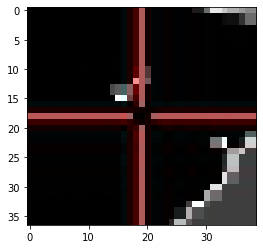

In [58]:
visualize_all_image(target_file_linear)

(<anatomist.cpp.anatomist.SliceableObject object at 0x7f43fc16df78>,
 <anatomist.cpp.weak_shared_ptr_AWindow object at 0x7f43fc0e5a68>)

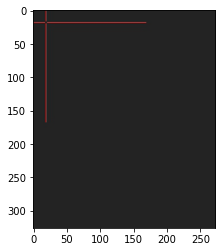

In [59]:
visualize_all_image(vol_source_file)